In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 29.2 MB 6.0 MB/s 
     |████████████████████████████████| 776.8 MB 9.2 MB/s 
     |████████████████████████████████| 12.8 MB 3.3 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import random_split
from torch.distributions import Distribution
from torch import nn, Tensor
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
from skimage.transform import resize
from torch.utils.data import random_split
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import torchvision.transforms as transforms
import torchvision
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions import Bernoulli, Normal, MultivariateNormal

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/opt/venv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Prepare Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
# Load data:
transform = transforms.Compose(
    [transforms.ToTensor()
    ]
)


# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


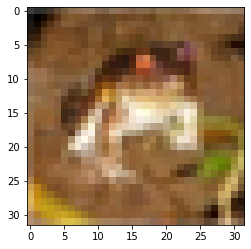

In [ ]:
# Tranform input data into (8,8)
#from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

input_trainset = trainset
output_trainset = trainset

tmp = trainset[0][0]
tmp.size()
plt.imshow(tmp.permute(1,2,0))

In [ ]:
downscaled_input = []
for datapoint in input_trainset:
    image = datapoint[0]
    resized_image = resize(image, output_shape = (3,16,16), mode='reflect', anti_aliasing=True)
    downscaled_input.append(torch.from_numpy(resized_image))


In [ ]:
output = []
for datapoint in input_trainset:
    image = datapoint[0]
    output.append(torch.Tensor(image))

In [ ]:
trainset = []
for i in range(len(downscaled_input)):
    trainset.append(((downscaled_input[i],output[i])))


train_size = len(trainset)
val_size = int(np.floor(train_size * 0.1))
train_size = int(train_size - val_size)
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(validset, batch_size=5,
                                          shuffle=True, num_workers=0)


In [ ]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        #return torch.normal(mean = self.mu, std = self.sigma) 
        return self.mu + self.sigma*self.sample_epsilon()
        #raise NotImplementedError # <- your code
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        #dist = torch.distributions.Normal(self.mu, self.sigma)
        #return dist.log_prob(z)
        return torch.log(1e-3+1/(self.sigma*np.sqrt(2*np.pi))) -1/2*((z-self.mu)/(self.sigma+1e-3))**2
        #raise NotImplementedError # <- your code

# Preprocess data

In [ ]:
from torch import nn

class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = num_channels,
                                out_channels = 10, 
                                kernel_size = 3,
                                padding = 2)
        self.conv2 = nn.Conv2d(in_channels= 10,
                                out_channels = 5,
                                kernel_size = 2,
                                padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 5,
                                out_channels = num_channels, 
                                kernel_size = 2, 
                                padding = 0)
        self.relu = nn.ReLU(inplace=True)
        self.batchn1 = nn.BatchNorm2d(256)
        self.batchn2 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(size = (32,32), mode = "bicubic")
        self.flat = nn.Flatten(start_dim = 1, end_dim = -1)
        self.lin = nn.Linear(in_features=3*13*13, out_features= 3*32*32)
        self.lin2 = nn.Linear(in_features=3*16*16, out_features= 3*32*32)
        self.unflat = nn.Unflatten(dim = 1, unflattened_size=(3,32,32))

    def forward(self, x):
        x = self.up(x)
        #print(x.shape)
        #x = self.flat(x)
        #x = self.relu(self.lin2(x))
        #print(x.shape)
        #x = self.unflat(x)
        #print(x.shape)
        x = self.relu(self.conv1(x))
        #x = self.batchn1(x)
        x = self.relu(self.conv2(x))
        #x = self.batchn2(x)
        x = self.relu(self.conv3(x))
        #print(x.shape)
        x = self.flat(x)
        #print(x.shape)
        #x = self.lin(x)
        #x = self.Sigmoid(x)
        #x = self.unflat(x)
        return x

In [ ]:
model = SRCNN().to(device)
print(model)

SRCNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 5, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(5, 3, kernel_size=(2, 2), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (batchn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up): Upsample(size=(32, 32), mode=bicubic)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=507, out_features=3072, bias=True)
  (lin2): Linear(in_features=768, out_features=3072, bias=True)
  (unflat): Unflatten(dim=1, unflattened_size=(3, 32, 32))
)


## Optimizer and Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)

In [ ]:
num_epochs = 20
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)
from torch.autograd import Variable
nsamples = 1000
valLoss = np.zeros(num_epochs)
trainLoss = np.zeros(num_epochs)
for epoch in range(num_epochs):

    model.eval()
    valError = 0
    c1 = 0
    for i, data in enumerate(val_loader):
        if i > nsamples:
            break
        inputs, outputs = data
        inputs = inputs.to(device)
        outputs = torch.Tensor(np.array(outputs))
        outputs = outputs.to(device)
        inputs, outputs = Variable(inputs, requires_grad=True), Variable(outputs, requires_grad=True)
        prediction = model(inputs)
        log_sigma = -3*torch.ones(prediction.shape)
        preds = ReparameterizedDiagonalGaussian(prediction, log_sigma)
        #print(preds.log_prob(outputs.view(-1,3*32*32)))
        loss = -reduce(preds.log_prob(outputs.view(-1,3*32*32))).mean()
        #print(loss)
        #loss = criterion(prediction, outputs)

        valError += loss.item()#.data[0]
        c1 += 1
        #print(valError)

    model.train()
    trainError = 0
    c2 = 0
    for i, data in enumerate(trainloader):
        if i > nsamples:
            break
        inputs, outputs = data
        inputs = inputs.to(device)
        outputs = torch.Tensor(np.array(outputs))
        outputs = outputs.to(device)
        inputs, outputs = Variable(inputs, requires_grad=True), Variable(outputs, requires_grad=True)

        optimizer.zero_grad()
        prediction = model(inputs)
        log_sigma = -3*torch.ones(prediction.shape)
        preds = ReparameterizedDiagonalGaussian(prediction, log_sigma)
        #print(preds.log_prob(outputs.view(-1,3*32*32)))
        loss = -reduce(preds.log_prob(outputs.view(-1,3*32*32))).mean()
        #loss = criterion(prediction, outputs)
        #loss = Variable(loss, requires_grad = True)
        loss.backward()
        optimizer.step()
        tmp = loss.clone()
        trainError += tmp.detach().numpy()
        #trainError += loss#.data[0]
        c2 += 1
        #if i % 1000 == 999:    # print every 1000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0

    trainLoss[epoch] = trainError/c2
    valLoss[epoch] = valError/c1
    print("Epoch ", epoch)
    print("Mean Validation error", valError/c1)
    print("Mean Training error", trainError/c2)

Epoch  0
Mean Validation error 144336.9069140625
Mean Training error 2559.3237531587674
Epoch  1
Mean Validation error -4204.786270263672
Mean Training error -4596.720901656937
Epoch  2
Mean Validation error -4697.402563232422
Mean Training error -4730.22659152371
Epoch  3
Mean Validation error -4775.059103271485
Mean Training error -4777.7417777534965
Epoch  4
Mean Validation error -4836.067633544922
Mean Training error -4852.748769297109
Epoch  5
Mean Validation error -4877.4596596679685
Mean Training error -4879.746972997706
Epoch  6
Mean Validation error -4889.042526123047
Mean Training error -4911.825068973994
Epoch  7
Mean Validation error -4905.52837109375
Mean Training error -4894.001093876826
Epoch  8
Mean Validation error -4934.5026689453125
Mean Training error -4928.771585592142
Epoch  9
Mean Validation error -4946.124084960938
Mean Training error -4961.334150224775
Epoch  10
Mean Validation error -4940.749826660156
Mean Training error -4949.594835096544
Epoch  11
Mean Valid

Text(0.5, 1.0, 'SRCNN Loss')

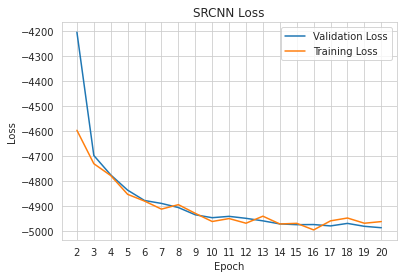

In [ ]:

plt.plot(range(2,21),valLoss[1:])
plt.plot(range(2,21),trainLoss[1:])
#plt.ylim([-5000,10000])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(2,21))
plt.legend(("Validation Loss","Training Loss"))
plt.title("SRCNN Loss")

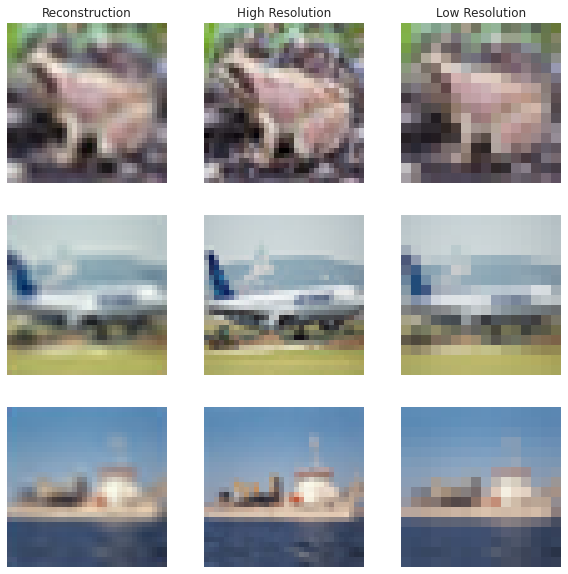

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    x,y = next(iter(trainloader))
    prediction = model((x))
    prediction = prediction.view(-1, *(3,32,32))
    #prediction = prediction.cpu().detach().numpy()
    plt.subplot(3,3,i*3+1)
    plt.imshow(prediction[0].detach().permute(1,2,0))
    plt.axis("off")
    if i == 0:
        plt.title("Reconstruction")

    plt.subplot(3,3,i*3+2)
    plt.imshow(y[0].detach().permute(1,2,0))
    plt.axis("off")
    if i == 0:
        plt.title("High Resolution")
    plt.subplot(3,3,i*3+3)
    plt.imshow(x[0].detach().permute(1,2,0))
    plt.axis("off")
    if i == 0:
        plt.title("Low Resolution")
    #plt.imshow(prediction[0][2])

In [ ]:
prediction[0].shape

torch.Size([3, 32, 32])

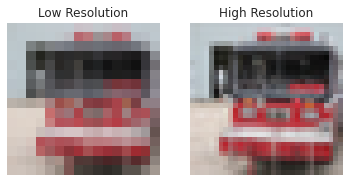

In [ ]:
x,y = next(iter(trainloader))
prediction = prediction.view(-1, *(3,32,32))
#prediction = prediction.cpu().detach().numpy()
plt.subplot(1,2,1)
plt.imshow(x[0].detach().permute(1,2,0))
plt.title("Low Resolution")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(y[0].detach().permute(1,2,0))
#plt.imshow(prediction[0][2])
plt.title("High Resolution")
plt.axis("off")
plt.savefig('lowhighres.eps', format='eps')

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([11.87990548,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])